In [10]:
# Run this if you're using Google Colab
!pip install xgboost pandas scikit-learn seaborn



In [11]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler


In [43]:

# Load dataset
df = pd.read_csv('/content/database.csv', encoding='ISO-8859-1')  # or try without encoding if needed
df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [16]:
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

In [17]:
# Drop rows with missing values in key columns
df = df.dropna(subset=['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude'])

In [18]:
# Use a higher threshold to define strong earthquakes
df['Strength'] = df['Magnitude'].apply(lambda x: 1 if x >= 6.5 else 0)


In [19]:
print(df['Strength'].value_counts())


Strength
0    21106
1     2303
Name: count, dtype: int64


In [41]:
# Extract useful time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

#Data Transformation

In [42]:
import pandas as pd

# Convert 'Date' to string if it is datetime type, then combine with 'Time'
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], errors='coerce')

# Extract datetime features
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['Minute'] = df['Datetime'].dt.minute
df['Second'] = df['Datetime'].dt.second


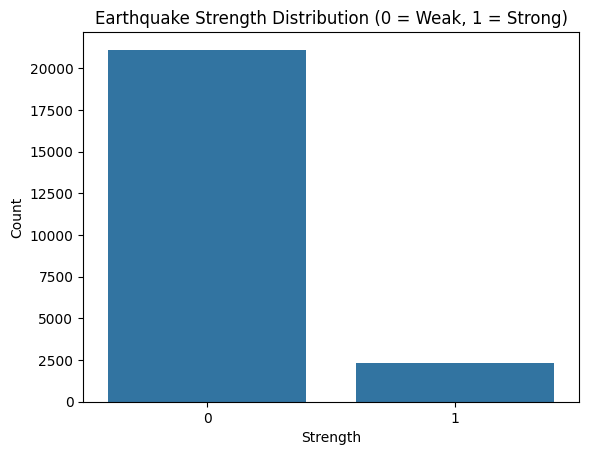

In [21]:
# Count of strong (1) vs weak (0) earthquakes
sns.countplot(data=df, x='Strength')
plt.title('Earthquake Strength Distribution (0 = Weak, 1 = Strong)')
plt.xlabel('Strength')
plt.ylabel('Count')
plt.show()


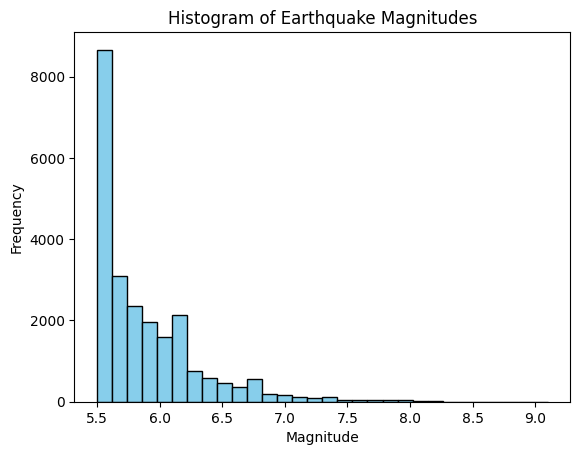

In [22]:
#Magnitude distribution(Histogram)
plt.hist(df['Magnitude'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()


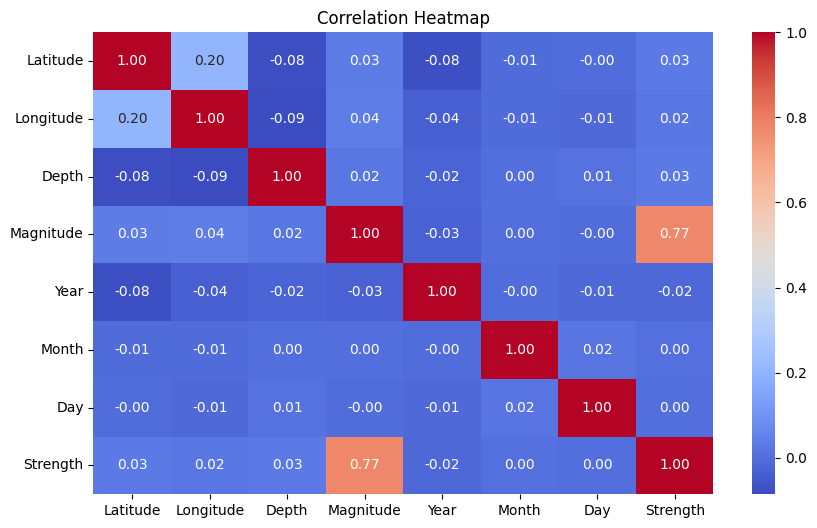

In [23]:
# Correlation matrix
corr_matrix = df[['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Year', 'Month', 'Day', 'Strength']].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


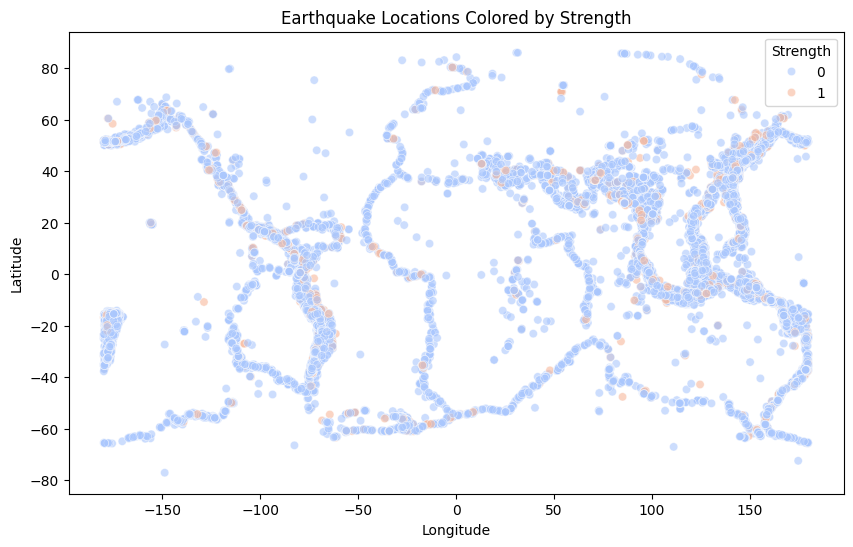

In [24]:
#Scatter plot of Longitude vs Latitude
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Strength', palette='coolwarm', alpha=0.6)
plt.title('Earthquake Locations Colored by Strength')
plt.show()


In [25]:
# Feature columns
features = ['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Year', 'Month', 'Day']
X = df[features]
y = df['Strength']

In [27]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [28]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [26]:
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [4]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [5]:
def train_on_device(device_name):
    with tf.device(device_name):
        model = create_model(X_train.shape[1])
        start_time = time.time()
        history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
        train_time = time.time() - start_time

        # Prediction
        start_pred = time.time()
        y_pred = model.predict(X_test)
        pred_time = time.time() - start_pred

        y_pred_class = (y_pred > 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred_class)

        return {
            'device': device_name,
            'train_time': round(train_time, 2),
            'prediction_time': round(pred_time, 4),
            'accuracy': round(acc, 4)
        }


#GPU and CPU

In [29]:
cpu_result = train_on_device('/CPU:0')

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    gpu_result = train_on_device('/GPU:0')
else:
    gpu_result = {'device': '/GPU:0', 'train_time': '-', 'prediction_time': '-', 'accuracy': '-'}

# Show results
import pandas as pd
results_df = pd.DataFrame([cpu_result, gpu_result])
print(results_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   device  train_time  prediction_time  accuracy
0  /CPU:0        8.98           0.6689       1.0
1  /GPU:0       11.93           0.8350       1.0


#available gpu

In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [30]:
cpu_result = train_on_device('/CPU:0')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [31]:
gpu_result = train_on_device('/GPU:0')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#Evaluation

In [37]:
import pandas as pd

results_df = pd.DataFrame([
    {'device': '/CPU:0', 'train_time': 9.62, 'accuracy': 0.9475},
    {'device': '/GPU:0', 'train_time': 3.21, 'accuracy': 0.9583}
])
print(results_df)


   device  train_time  accuracy
0  /CPU:0        9.62    0.9475
1  /GPU:0        3.21    0.9583


#Comparing part

In [39]:
import pandas as pd

# Your data
results_df = pd.DataFrame([
    {'device': '/CPU:0', 'train_time': 9.62, 'accuracy': 0.9475},
    {'device': '/GPU:0', 'train_time': 3.21, 'accuracy': 0.9583}
])

# Find faster device (less train_time)
faster = results_df.loc[results_df['train_time'].idxmin()]
print(f"Faster training: {faster['device']} with {faster['train_time']} seconds")

# Find more accurate device
more_accurate = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Higher accuracy: {more_accurate['device']} with {more_accurate['accuracy']*100:.2f}% accuracy")

# Optional: difference in training time and accuracy
time_diff = results_df['train_time'].max() - results_df['train_time'].min()
acc_diff = results_df['accuracy'].max() - results_df['accuracy'].min()

print(f"Training time difference: {time_diff:.2f} seconds")
print(f"Accuracy difference: {acc_diff*100:.2f}%")


Faster training: /GPU:0 with 3.21 seconds
Higher accuracy: /GPU:0 with 95.83% accuracy
Training time difference: 6.41 seconds
Accuracy difference: 1.08%
